In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import pandas as pd
import glob
from sklearn import model_selection
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import sys
from torch.nn.utils.rnn import pack_padded_sequence
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.misc import imresize


%matplotlib inline

In [2]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
def show_img(img, cmap=None):
    _, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
    ax.imshow(img, cmap=cmap)
    plt.show()

In [4]:
all_NT = []
all_T = []

for player in ['01', '02', '06', '07', '08', '09', '10', '11']:
    for pos in ['L', 'R']:
        
        eegNT = []
        eegT = []

        eegNT_files = glob.glob(player + '_300_200_500_' + pos + '_eegNT_*.csv')
        eegT_files = glob.glob(player + '_300_200_500_' + pos + '_eegT_*.csv')

        for fname in eegNT_files:
            eegNT.append(pd.DataFrame().from_csv(fname, header=None, index_col=None).values)
    
        for fname in eegT_files:
            eegT.append(pd.DataFrame().from_csv(fname, header=None, index_col=None).values)
    
        eegNT = np.stack(eegNT).transpose(2, 1, 0)
        eegT = np.stack(eegT).transpose(2, 1, 0)
        
        all_NT.append(eegNT)
        all_T.append(eegT)

In [5]:
sNT = 0
sT = 0
for NT in all_NT:
    sNT += NT.shape[0]

for T in all_T:
    sT += T.shape[0]
    
print(sNT, sT)

1272 1240


In [6]:
X_train = []
X_test = []

for eeg in all_T:
    temp_X_train, temp_X_test = model_selection.train_test_split(eeg, test_size=1/6)
    X_train.append(temp_X_train)
    X_test.append(temp_X_test)

X_train = np.concatenate(X_train, axis=0)
X_test = np.concatenate(X_test, axis=0)
y_train = np.ones((X_train.shape[0], 1))
y_test = np.ones((X_test.shape[0], 1))

for eeg in all_NT:
    temp_X_train, temp_X_test = model_selection.train_test_split(eeg, test_size=1/6)
    X_train = np.concatenate((X_train, temp_X_train), axis=0)
    X_test = np.concatenate((X_test, temp_X_test), axis=0)
    y_train = np.concatenate((y_train, np.zeros((temp_X_train.shape[0], 1))), axis=0)
    y_test = np.concatenate((y_test, np.zeros((temp_X_test.shape[0], 1))), axis=0)

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2079, 23, 50)
(433, 23, 50)
(2079, 1)
(433, 1)


In [8]:
# top 8; bot 9; left 12; right 12

def preprocess_old1(eeg_batch):
    new_batch = []
    for eeg in log_progress(eeg_batch):
        baseline = eeg[ :, :17].mean(1)
        new_eeg = eeg - np.reshape(baseline, (-1, 1))
        norm = np.max(np.abs(new_eeg))
        eeg_color = []
        eeg_color.append(imresize(new_eeg.clip(min=0) / norm,  (224, 224), interp='nearest'))
        eeg_color.append(imresize(new_eeg.clip(max=0) / norm,  (224, 224), interp='nearest'))
        eeg_color.append(np.zeros((224, 224)))
        eeg_color = np.stack(eeg_color)
        new_batch.append(eeg_color)
    return np.stack(new_batch)

def preprocess_old2(eeg_batch):
    new_batch = []
    for eeg in log_progress(eeg_batch):
        baseline = eeg[ :, :17].mean(1)
        new_eeg = eeg - np.reshape(baseline, (-1, 1))
        norm = np.max(np.abs(new_eeg))
        eeg_color = []
        eeg_color.append(imresize(new_eeg.clip(min=0) / norm * 255,  (224, 224), interp='nearest') / 255)
        eeg_color.append(imresize(new_eeg.clip(max=0) / norm * 255,  (224, 224), interp='nearest') / 255)
        eeg_color.append(np.zeros((224, 224)))
        eeg_color = np.stack(eeg_color)
        new_batch.append(eeg_color)
    return np.stack(new_batch)

def preprocess_large(eeg_batch):
    new_batch = []
    for eeg in log_progress(eeg_batch):
        baseline = eeg[ :, :17].mean(1)
        new_eeg = eeg - np.reshape(baseline, (-1, 1))
        norm = np.max(np.abs(new_eeg))
        eeg_color = []
        old_chan0 = new_eeg.clip(min=0) / norm
        new_chan0 = np.zeros((250, 250))
        old_chan1 = new_eeg.clip(max=0) / norm
        new_chan1 = np.zeros((250, 250))
        for i in range(old_chan0.shape[0]):
            for j in range(old_chan0.shape[1]):
                new_chan0[13+8+i*9:13+8+(i+1)*9, 13+12+j*4:13+12+(j+1)*4] = old_chan0[i, j]
                new_chan1[13+8+i*9:13+8+(i+1)*9, 13+12+j*4:13+12+(j+1)*4] = old_chan1[i, j]
        eeg_color.append(new_chan0)
        eeg_color.append(new_chan1)
        eeg_color.append(np.zeros((250, 250)))
        eeg_color = np.stack(eeg_color)
        new_batch.append(eeg_color)
    return np.stack(new_batch)

def preprocess(eeg_batch):
    new_batch = []
    for eeg in log_progress(eeg_batch):
        baseline = eeg[ :, :17].mean(1)
        new_eeg = eeg - np.reshape(baseline, (-1, 1))
        norm = np.max(np.abs(new_eeg))
        eeg_color = []
        old_chan0 = new_eeg.clip(min=0) / norm
        new_chan0 = np.zeros((224, 224))
        old_chan1 = new_eeg.clip(max=0) / norm
        new_chan1 = np.zeros((224, 224))
        for i in range(old_chan0.shape[0]):
            for j in range(old_chan0.shape[1]):
                new_chan0[8+i*9:8+(i+1)*9, 12+j*4:12+(j+1)*4] = old_chan0[i, j]
                new_chan1[8+i*9:8+(i+1)*9, 12+j*4:12+(j+1)*4] = old_chan1[i, j]
        eeg_color.append(new_chan0)
        eeg_color.append(new_chan1)
        eeg_color.append(np.zeros((224, 224)))
        eeg_color = np.stack(eeg_color)
        new_batch.append(eeg_color)
    return np.stack(new_batch)

def preprocess_old3(eeg_batch):
    new_batch = []
    for eeg in log_progress(eeg_batch):
        baseline = eeg[ :, :17].mean(1)
        new_eeg = eeg - np.reshape(baseline, (-1, 1))
        norm = np.max(np.abs(new_eeg))
        eeg_color = []
        eeg_color.append(new_eeg.clip(min=0) / norm * 255)
        eeg_color.append(new_eeg.clip(max=0) / norm * 255)
        eeg_color.append(np.zeros(new_eeg.shape))
        eeg_color = np.stack(eeg_color)
        eeg_color = imresize(eeg_color, (224, 224), interp='nearest').transpose(2, 0, 1) / 255
        eeg_color[2, :, :] = 0
        new_batch.append(eeg_color)
    return np.stack(new_batch)



def preprocess2(eeg_batch):
    new_batch = []
    for eeg in log_progress(eeg_batch):
        baseline = eeg[ :, :17].mean(1)
        new_eeg = eeg - np.reshape(baseline, (-1, 1))
        norm = np.max(np.abs(new_eeg))
        eeg_color = []
        eeg_color.append(new_eeg.clip(min=0) / norm)
        eeg_color.append(new_eeg.clip(max=0) / norm)
        eeg_color.append(np.zeros(new_eeg.shape))
        eeg_color = np.stack(eeg_color)
        new_batch.append(eeg_color)
    return np.stack(new_batch)

X_diff_train = preprocess(X_train)
X_diff_test = preprocess(X_test)
print(X_diff_train.shape, X_diff_test.shape)

X_diff_train2 = preprocess2(X_train)
X_diff_test2 = preprocess2(X_test)
print(X_diff_train2.shape, X_diff_test2.shape)

A Jupyter Widget

A Jupyter Widget

(2079, 3, 224, 224) (433, 3, 224, 224)


A Jupyter Widget

A Jupyter Widget

(2079, 3, 23, 50) (433, 3, 23, 50)


In [9]:
show_ind = random.randint(0, X_diff_train.shape[0] - 1)
show_img(X_diff_train[show_ind].transpose(1, 2, 0))

In [10]:
show_img(X_diff_train2[show_ind].transpose(1, 2, 0))

(3, 207, 200)


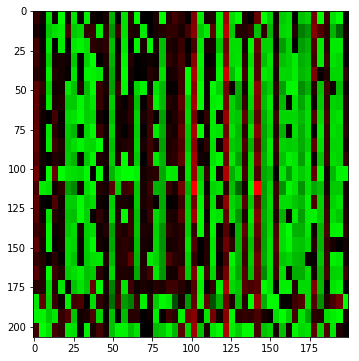

In [27]:
print(X_diff_train[0, :, 8:-9, 12:-12].shape)

show_img(X_diff_train[show_ind, :, 8:-9, 12:-12].transpose(1, 2, 0))

(3, 224, 224)


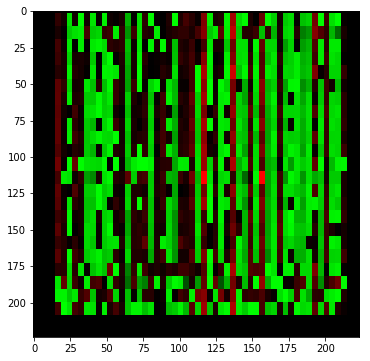

In [31]:
h_shift = random.randint(0, 24)
v_shift = random.randint(0, 17)
new = np.lib.pad(X_diff_train[show_ind, :, 8:-9, 12:-12], ((0, 0), (v_shift, 17-v_shift), (h_shift, 24-h_shift)), 'constant')
print(new.shape)
                 
show_img(new.transpose(1, 2, 0))

In [32]:
class vgg19_to_2(nn.Module):
    def __init__(self):
        super(vgg19_to_2, self).__init__()
        self.model = models.vgg19(pretrained=True)
        self.model.eval
        mod = list(self.model.classifier.children())
        mod.pop()
        mod.append(torch.nn.Linear(128, 2))
        mod[3] = torch.nn.Linear(1024, 128)
        mod[0] = torch.nn.Linear(25088, 1024)
        new_classifier = torch.nn.Sequential(*mod)
        self.model.classifier = new_classifier
        print(self.model)

        self.init_weights()

    def init_weights(self):
        """Initialize the weights."""
        for i in [0, 3, 6]:   
            self.model.classifier[i].weight.data.normal_(0.0, 0.02)
            self.model.classifier[i].bias.data.fill_(0)


    def forward(self, images):
        """Получаем вектор фич."""
        features = self.model(images)
        return F.log_softmax(features)
    
net = vgg19_to_2().cuda()

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU (inplace)
    (18): MaxPool2d (size=(

In [ ]:
learning_rate = 1e-3
batch_size = 50
iters = 100
optimizer = torch.optim.Adam(net.model.classifier.parameters(), lr=learning_rate)
loss_fn = torch.nn.NLLLoss().cuda()


for iter in log_progress(range(iters), name='Epochs'):
    net.model.classifier.train(True)
    Xperm = np.random.permutation(X_diff_train.shape[0])
    loss_acc = 0
    test_loss_acc = 0
    test_accur = 0
    for b in log_progress(range(X_diff_train.shape[0] // batch_size)):
        optimizer.zero_grad()
        idx = Xperm[b*batch_size:(b+1)*batch_size]
        #h_shift = random.randint(0, 26)
        #v_shift = random.randint(0, 26)
        h_shift = random.randint(0, 24)
        v_shift = random.randint(0, 17)
        #x = Variable(torch.from_numpy(X_diff_train[idx][:, :, h_shift:224+h_shift, v_shift:224+v_shift])).float().cuda()
        x = Variable(torch.from_numpy(np.lib.pad(X_diff_train[idx][:, :, 8:-9, 12:-12], ((0, 0), (0, 0), (v_shift, 17-v_shift), (h_shift, 24-h_shift)), 'constant'))).float().cuda()
        y = Variable(torch.from_numpy(y_train[idx])).squeeze(1).long().cuda()
        y_pred = net(x)
        loss = loss_fn(y_pred, y)
        
        loss.backward()
        
        loss_acc += loss.data[0]
        optimizer.step()
    net.model.classifier.train(False)
    Xperm = np.random.permutation(X_diff_test.shape[0])
    for b in log_progress(range(X_diff_test.shape[0] // batch_size)):
        idx = Xperm[b*batch_size:(b+1)*batch_size]
        x = Variable(torch.from_numpy(X_diff_test[idx]), volatile=True).float().cuda()
        y = Variable(torch.from_numpy(y_test[idx]), volatile=True).squeeze(1).long().cuda()
        y_pred = net(x)
        loss = loss_fn(y_pred, y)
        for i in range(y_test[idx].shape[0]):
            if int(y_test[idx][i][0]) == np.exp(y_pred.data.cpu().numpy()[i]).argmax():
                test_accur += 1
        test_loss_acc += loss.data[0]
    test_accur /= X_diff_test.shape[0]
    sys.stdout.write('iter: %d, total train loss: %.3f,  total test loss: %.3f, total test acc: %.3f,\n'%(iter, loss_acc, test_loss_acc, test_accur))


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

iter: 0, total train loss: 29.611,  total test loss: 5.510, total test acc: 0.529,


A Jupyter Widget

A Jupyter Widget

iter: 1, total train loss: 28.329,  total test loss: 5.470, total test acc: 0.575,


A Jupyter Widget

A Jupyter Widget

iter: 2, total train loss: 27.636,  total test loss: 5.267, total test acc: 0.587,


A Jupyter Widget

A Jupyter Widget

iter: 3, total train loss: 26.885,  total test loss: 5.245, total test acc: 0.577,


A Jupyter Widget

A Jupyter Widget

iter: 4, total train loss: 26.677,  total test loss: 5.059, total test acc: 0.582,


A Jupyter Widget

A Jupyter Widget

iter: 5, total train loss: 25.653,  total test loss: 5.083, total test acc: 0.591,


A Jupyter Widget

A Jupyter Widget

iter: 6, total train loss: 25.214,  total test loss: 5.125, total test acc: 0.580,


A Jupyter Widget

A Jupyter Widget

iter: 7, total train loss: 24.814,  total test loss: 5.102, total test acc: 0.557,


A Jupyter Widget

A Jupyter Widget

iter: 8, total train loss: 24.413,  total test loss: 4.941, total test acc: 0.584,


A Jupyter Widget

A Jupyter Widget

iter: 9, total train loss: 24.562,  total test loss: 5.052, total test acc: 0.605,


A Jupyter Widget

A Jupyter Widget

iter: 10, total train loss: 23.514,  total test loss: 5.061, total test acc: 0.580,


A Jupyter Widget

A Jupyter Widget

iter: 11, total train loss: 23.304,  total test loss: 5.043, total test acc: 0.596,


A Jupyter Widget

A Jupyter Widget

iter: 12, total train loss: 22.681,  total test loss: 5.566, total test acc: 0.566,


A Jupyter Widget

A Jupyter Widget

iter: 13, total train loss: 22.585,  total test loss: 4.879, total test acc: 0.614,


A Jupyter Widget

A Jupyter Widget

iter: 14, total train loss: 23.053,  total test loss: 4.993, total test acc: 0.600,


A Jupyter Widget

A Jupyter Widget

iter: 15, total train loss: 22.215,  total test loss: 4.897, total test acc: 0.637,


A Jupyter Widget

A Jupyter Widget

iter: 16, total train loss: 20.543,  total test loss: 4.981, total test acc: 0.610,


A Jupyter Widget

A Jupyter Widget

iter: 17, total train loss: 21.019,  total test loss: 4.842, total test acc: 0.614,


A Jupyter Widget

A Jupyter Widget

iter: 18, total train loss: 21.639,  total test loss: 5.218, total test acc: 0.610,


A Jupyter Widget

A Jupyter Widget

iter: 19, total train loss: 20.312,  total test loss: 4.937, total test acc: 0.610,


A Jupyter Widget

A Jupyter Widget

iter: 20, total train loss: 20.260,  total test loss: 5.402, total test acc: 0.612,


A Jupyter Widget

A Jupyter Widget

iter: 21, total train loss: 20.328,  total test loss: 4.914, total test acc: 0.607,


A Jupyter Widget

A Jupyter Widget

iter: 22, total train loss: 19.814,  total test loss: 5.270, total test acc: 0.612,


A Jupyter Widget

A Jupyter Widget

iter: 23, total train loss: 19.260,  total test loss: 5.075, total test acc: 0.626,


A Jupyter Widget

A Jupyter Widget

iter: 24, total train loss: 18.966,  total test loss: 5.927, total test acc: 0.596,


A Jupyter Widget

A Jupyter Widget

iter: 25, total train loss: 18.314,  total test loss: 5.306, total test acc: 0.596,


A Jupyter Widget

A Jupyter Widget

iter: 26, total train loss: 17.738,  total test loss: 5.638, total test acc: 0.589,


A Jupyter Widget

A Jupyter Widget

iter: 27, total train loss: 17.370,  total test loss: 5.535, total test acc: 0.617,


A Jupyter Widget

A Jupyter Widget

iter: 28, total train loss: 17.391,  total test loss: 5.359, total test acc: 0.603,


A Jupyter Widget

A Jupyter Widget

iter: 29, total train loss: 17.571,  total test loss: 5.386, total test acc: 0.605,


A Jupyter Widget

A Jupyter Widget

iter: 30, total train loss: 16.925,  total test loss: 5.858, total test acc: 0.598,


A Jupyter Widget

In [ ]:
batch_size = 1
net.model.classifier.train(False)
Xperm = np.random.permutation(X_diff_test.shape[0])
loss_acc = 0
res = 0
for b in log_progress(range(X_diff_test.shape[0] // batch_size)):
    idx = Xperm[b*batch_size:(b+1)*batch_size]
    x = Variable(torch.from_numpy(X_diff_test[idx]), volatile=True).float().cuda()
    y_pred = net(x)
    #print(np.exp(y_pred.data[0].cpu().numpy()), int(y_test[idx][0][0]), np.exp(y_pred.data[0].cpu().numpy()).argmax())
    if np.exp(y_pred.data[0].cpu().numpy()).argmax() == y_test[idx][0][0]:
        res += 1
    #loss = loss_fn(y_pred, Variable(torch.from_numpy(y_test[idx]), volatile=True).long().cuda().squeeze(0))    
    #loss_acc += loss.data[0]
res / X_diff_test.shape[0]